# **PatternCode: Tutorial**
PatternCode is a tool for estimation of error probabilities in OGM, and optimization of OGM experimental parameters such as the labeled genome pattern. See the paper for full details.

The steps described below are:

1. Read a genome sequence
2. Estimate the information theory model's parameters
3. Compare labeled patterns: Compute the error probability vs. DNA fragment length for two different labeled patterns and compare them

##   1. Read a genome sequence
Start by reading a genome sequence. For example here we read the first human chromosome.

The FASTA file can be downloaded from NCBI: https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000001405.40/.


In [7]:
from patterncode.tool import *
from Bio import SeqIO

for record in SeqIO.parse(HUMAN_GENOME_FASTA_FILE, 'fasta'):
    if 'Homo sapiens chromosome 1' in record.description:
        break
record.description

'NC_000001.11 Homo sapiens chromosome 1, GRCh38.p14 Primary Assembly'

Now, we take an example subsequence, which interests us, from the chromosome. For example here we take the first 10Mb of the chromosome. And print its last 80 letters.

In [3]:
sequence = str(record.seq[:10000000].upper())
print(sequence[-80:])

ATACATTTTATCTTAAGAATTAAGTTGGTCTGGGTGCAGTGGCTCACACCTGTAATCCCAGCACTTTGGGATGCTGAGGC


##   2. Estimate the information theory model's parameters
As we describe in the paper:

...the error probability, denoted by $\varepsilon$, is approximated as follows:
\begin{equation}
    \varepsilon = \Phi \left( \frac{\log(M) - nI - \frac{1}{2} \log(n)}{\sqrt{n V}} \right)
\end{equation}
where $\Phi$ is the standard normal cumulative distribution function, $M = 2 G / B$ with $G$ the total genomes length (sum of lengths of all target genome sequences), $n = L / B$ with $L$ the DNA fragment length, and $B$ the bin size. The mutual information $I$ (of $x$ and $y$) and the variance $V$ are computed from the joint and marginal distributions of the number of pattern occurrences in a bin of a genome sequence ($x$) and the number of detected labels in a bin of a DNA fragment ($y$), as follows. We define $r$ as the following log-ratio of joint and marginal distributions:
\begin{equation}
    r := \log \frac{p_{xy}(x, y)}{p_x(x)p_y(y)}
\end{equation}
where $p_{xy}=p_{y|x} p_x$ is the joint distribution of $x$ and $y$, and $p_y=\operatorname{E}_x [p_{y|x}]$ is the marginal distribution of $y$. Then, $I = \operatorname{E}_{xy}[r]$ and $V = \operatorname{Var}_{xy}[r]$. The only free parameters in this model that need to be estimated from the data are the pattern density distribution $p_x$ and the label detection likelihood $p_{y|x}$.
The label detection likelihood $p_{y|x}$ implicitly includes effects such as imperfect labeling efficiency (incomplete digestion), off-target sequence labeling (e.g. due to non-specific reaction of the labeling enzyme), and staining artifacts. This is due to the fact that it represents the probability of detecting a label in a bin of a DNA fragment, given the number of pattern occurrences in a bin of a genome sequence.
...

In practice one can estimate the $p_{y|x}$ parameter for their own experimental data, and also optimize for the best bin size (see section 2.1.2 in the paper).
However, here we provide a simple tool to estimate the parameter $p_{y|x}$, given two simply estimated values, and a chosen bin size:
1. Labeling efficiency (tpr): Or, true positive labeling rate per bin.
2. Off-target labeling rate (fpr): Or, false positive labeling rate per bin.

The result of this calculation is a 2x2 matrix for $p_{y|x}$.

In [11]:
likelihood_model = LikelihoodModel(
    tpr=.9, #   True positive labeling rate per bin
    fpr=.1, #   False positive labeling rate per bin
    bin_size=1000, #    Bin size in base pairs
)

likelihood_model.p_y_given_x

[[0.9, 0.1], [0.08999999999999997, 0.91]]

The full documentation for the LikelihoodModel class:

In [17]:
LikelihoodModel??

Init signature:
LikelihoodModel(
    *,
    tpr: float,
    fpr: float,
    p_y_given_x: list[list] = None,
    bin_size: int = 1000,
) -> None
Source:        
class LikelihoodModel(BaseModel):
    tpr: float
    "True positive labeling rate per bin"

    fpr: float
    "False positive labeling rate per bin"

    p_y_given_x: list[list] = None
    "Label detection likelihood per bin"

    bin_size: int = DEFAULT_BIN_SIZE
    "Bin size in base pairs"

    def __init__(self, **data):
        super().__init__(**data)
        tpr = self.tpr
        fpr = self.fpr
        p01 = fpr
        p11 = tpr + (1 - tpr) * fpr
        self.p_y_given_x = [
            [1 - p01, p01],
            [1 - p11, p11],
        ]
File:           ~/code/PatternCode/patterncode/tool.py
Type:           ModelMetaclass
Subclasses:     

##   3. Compare labeled patterns

Now, having estimated the parameters for the model, we can proceed to compute the error probability.
Here, for example, we are interested in comparing the patterns CTTAAG and GGAGGC, where we used the same $p_{y|x}$ for both patterns, for simplicity. The following will compute the error probability of both patterns for a range of fragment lengths from 10kb to 400kb.

In [18]:
evaluations = [
    PatternTool(
        sequence=sequence,
        pattern=pattern,
        p_y_given_x=likelihood_model.p_y_given_x,
        bin_size=likelihood_model.bin_size,
        fragment_len=np.geomspace(10e3, 400e3),
    ) for pattern in ['CTTAAG', 'GGAGGC']
]

The full documentation for the PatterTool class:


In [16]:
PatternTool??

Init signature:
PatternTool(
    *,
    sequence: str,
    pattern: str,
    fragment_len: int | numpy.ndarray = 50000,
    bin_size: int = 1000,
    genome_len: int = None,
    p_x: list = None,
    p_y_given_x: list[list] = None,
    p_err: float = None,
    positions: numpy.ndarray = None,
) -> None
Source:        
class PatternTool(BaseModel):
    sequence: str = Field(..., repr=False)
    "Genome sequence"

    pattern: str
    "Labeled pattern"

    fragment_len: int | np.ndarray = DEFAULT_MOLECULE_LEN
    "Fragment length in base pairs"

    bin_size: int = DEFAULT_BIN_SIZE
    "Bin size in base pairs"

    genome_len: int = None
    "Genome length in base pairs"

    p_x: list = None
    "Genome per-bin pattern count distribution"

    p_y_given_x: list[list] = None
    "Label detection likelihood per bin"

    p_err: float = None
    "Error probability of a maximum-likelihood decoder"

    _count_cap: int = None

    positions: np.ndarray = Field(None, repr=False)
    "Pattern

Now we plot the error probability vs fragment length, and compare labeled patterns.

It can be seen that the GGAGGC pattern has lower error probability in this scenario.

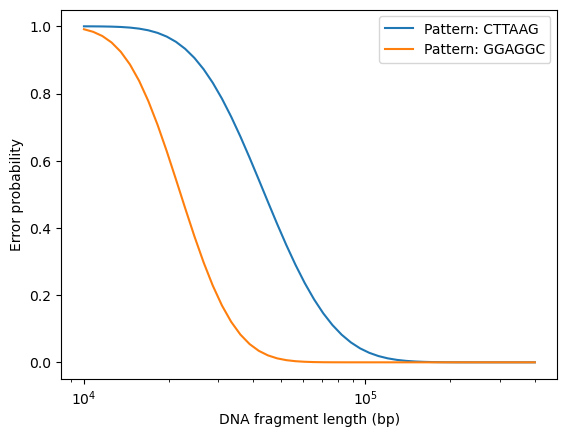

In [21]:
from matplotlib import pyplot as plt

for evaluation in evaluations:
    plt.plot(evaluation.fragment_len, evaluation.p_err)
    plt.xscale('log')
    plt.xlabel(MOLECULE_LENGTH)
    plt.ylabel(ERROR_PROBABILITY)

plt.legend([f'Pattern: {evaluation.pattern}' for evaluation in evaluations])

This concludes the tutorial!